In [8]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [9]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [10]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [11]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

lags = [1,2,3,4,5,6,7,8,9,10,11,12]

evaluator = MetricEvaluator()

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


### Raw

In [12]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [13]:
model = make_pipeline(
    MinMaxScaler(feature_range=(0,1)), 
    MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    )
)

fcst = MLForecast(
    models={'mlp': model},
    lags=lags,
    freq='MS'
)

In [14]:
fcst.fit(full_train)

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLForecast(models=[mlp], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [15]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [16]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [17]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['mlp'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations        MAE      MAPE          MSE  \
0    ACUCAR_SANTOS   mlp              20   7.987558  0.054403   109.404749   
1        ACUCAR_SP   mlp             100   5.556365  0.054123    45.222195   
2          ALGODAO   mlp             205  16.630892  0.050138   549.440107   
3            ARROZ   mlp             277   2.716183  0.044625    18.848388   
4     CAFE_ARABICA   mlp             381  26.073626  0.030642  4164.953677   
5     CAFE_ROBUSTA   mlp             468  28.799554  0.072566  2029.416371   
6            MILHO   mlp             543   2.582997  0.058712     9.226042   
7      SOJA_PARANA   mlp             644   5.614830  0.073322    36.274576   
8   SOJA_PARANAGUA   mlp             714   3.705865  0.040368    17.796985   
9     TRIGO_PARANA   mlp             791  29.431072  0.030868  1442.845047   
10        TRIGO_RS   mlp             868  21.002935  0.023082  1027.501833   

         RMSE        R2  
0   10.459673  0.116878  
1    6.7247

In [18]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                     MAPE                  \
          mean      std    min      max  median    mean     std     min   
Model                                                                     
mlp    13.6456  10.9494  2.583  29.4311  7.9876  0.0484  0.0165  0.0231   

                            MSE                                         \
          max  median      mean        std    min        max    median   
Model                                                                    
mlp    0.0733  0.0501  859.1755  1296.1827  9.226  4164.9537  109.4047   

          RMSE                                         R2                  \
          mean      std     min      max   median    mean     std     min   
Model                                                                       
mlp    21.6245  20.7536  3.0374  64.5365  10.4597  0.8804  0.2534  0.1169   

                       
          max  median  
Model           

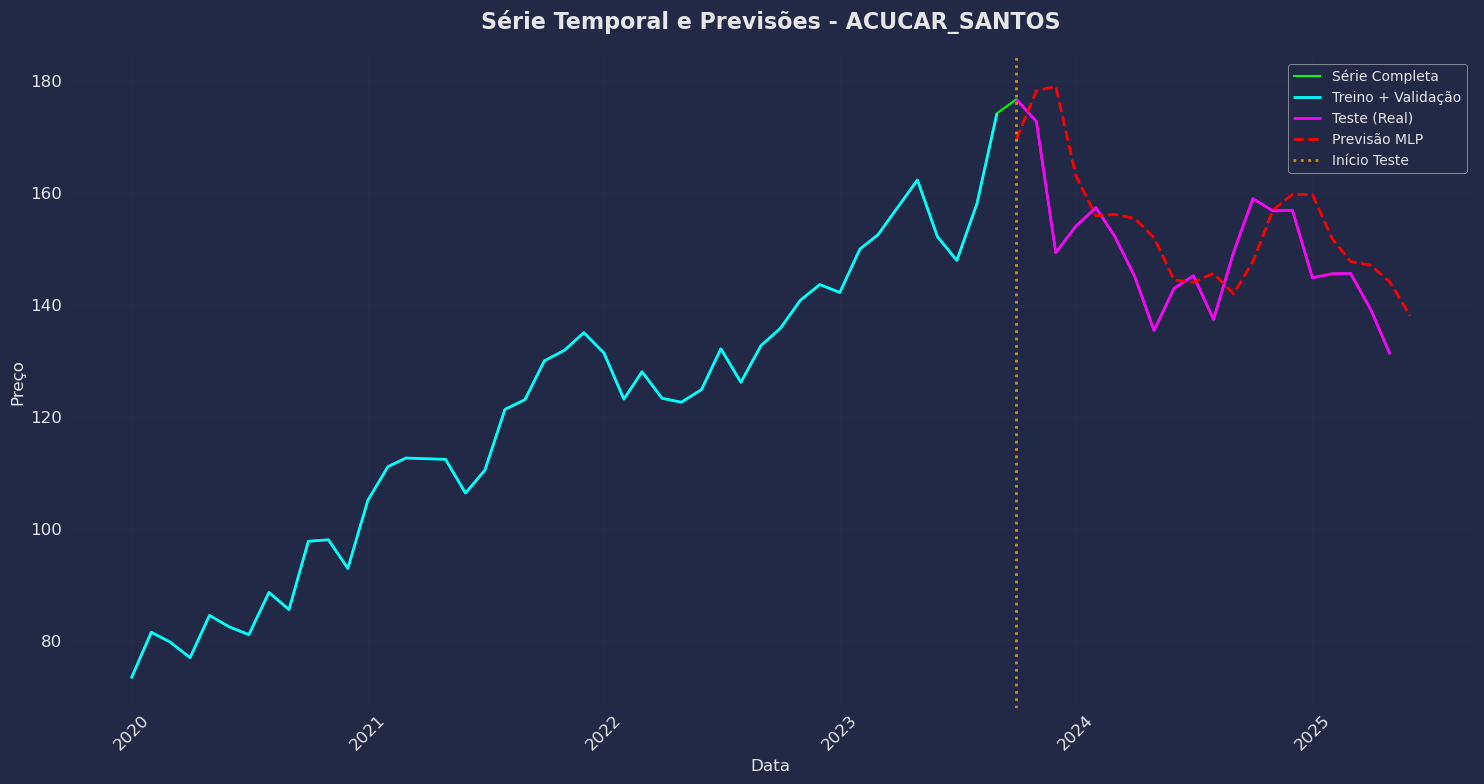

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


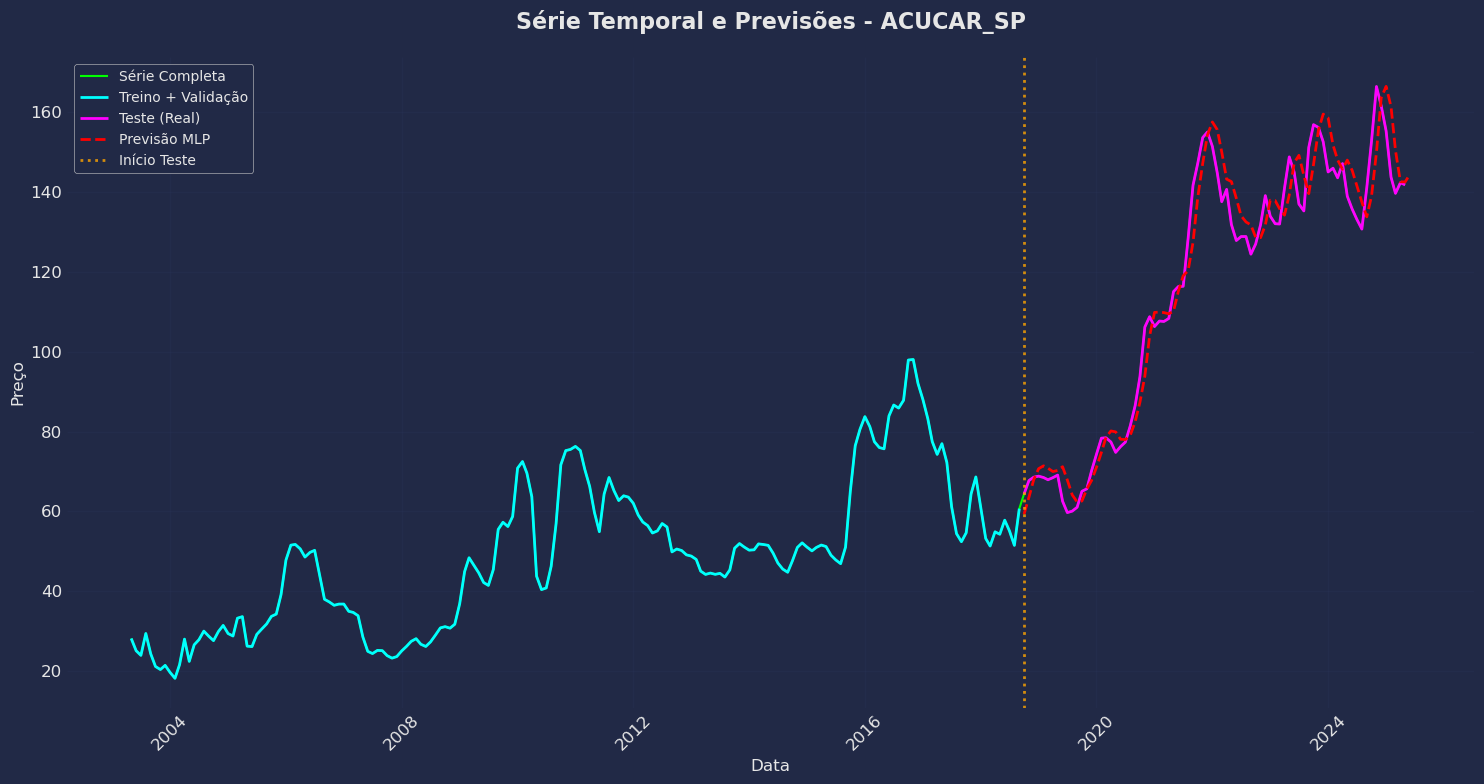

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


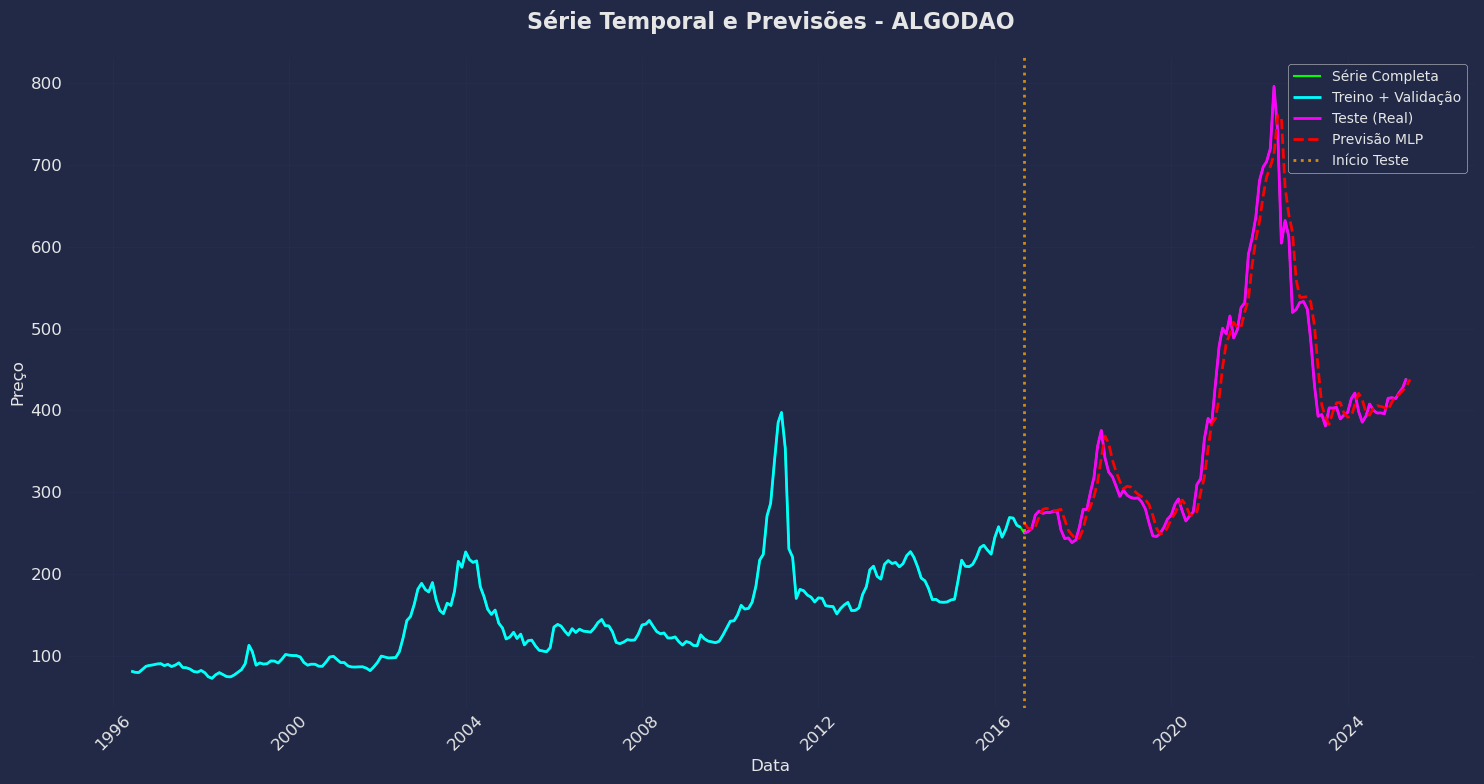

Gráfico exibido para: ALGODAO
--------------------------------------------------


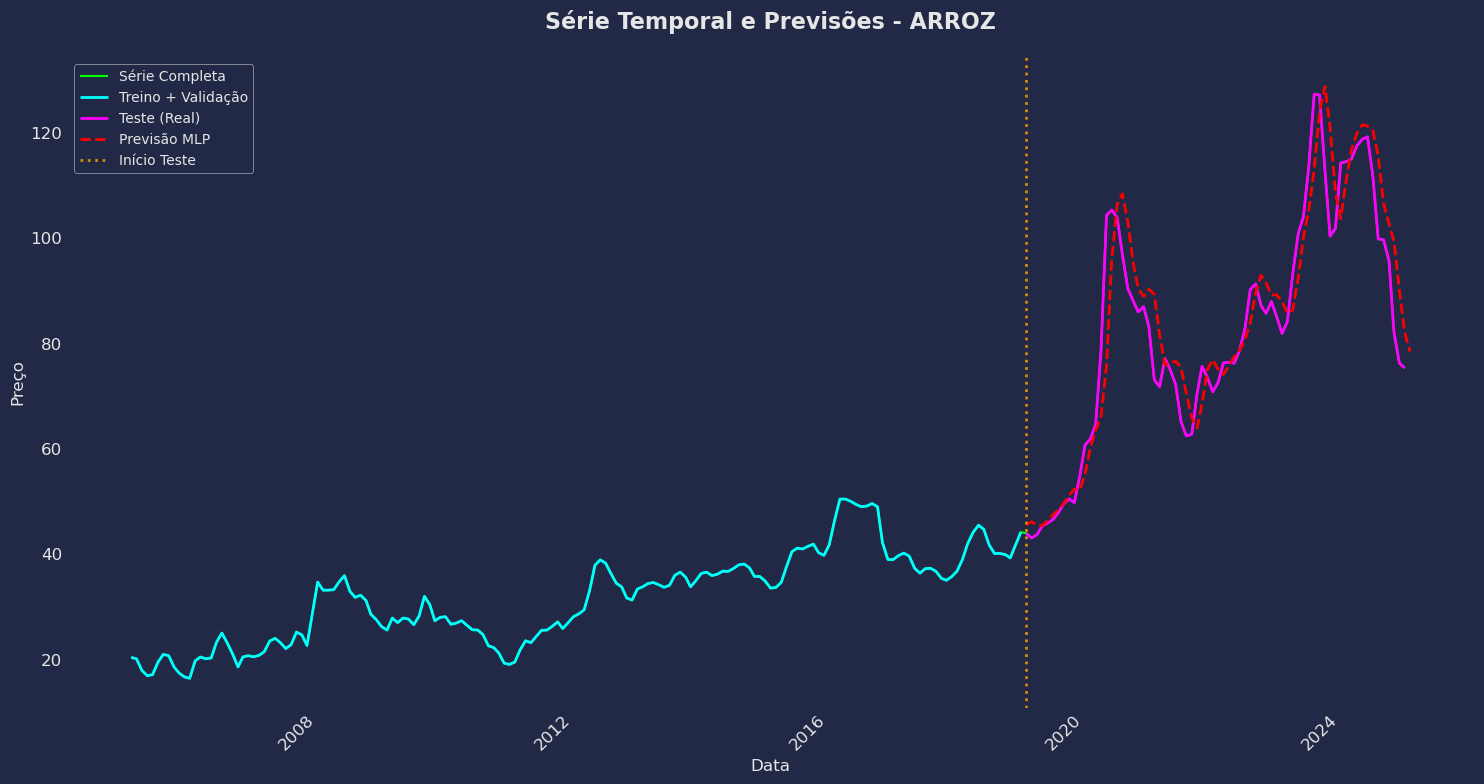

Gráfico exibido para: ARROZ
--------------------------------------------------


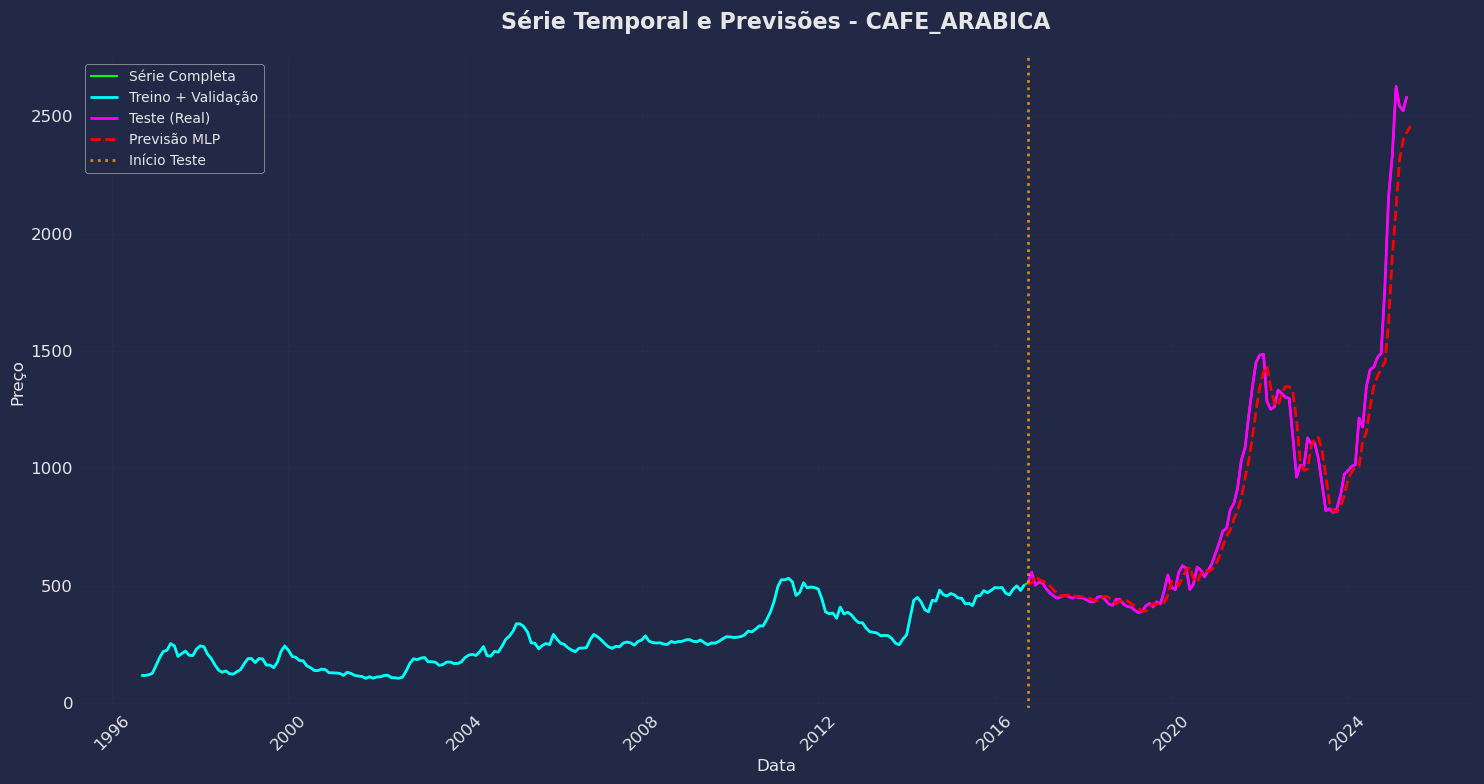

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


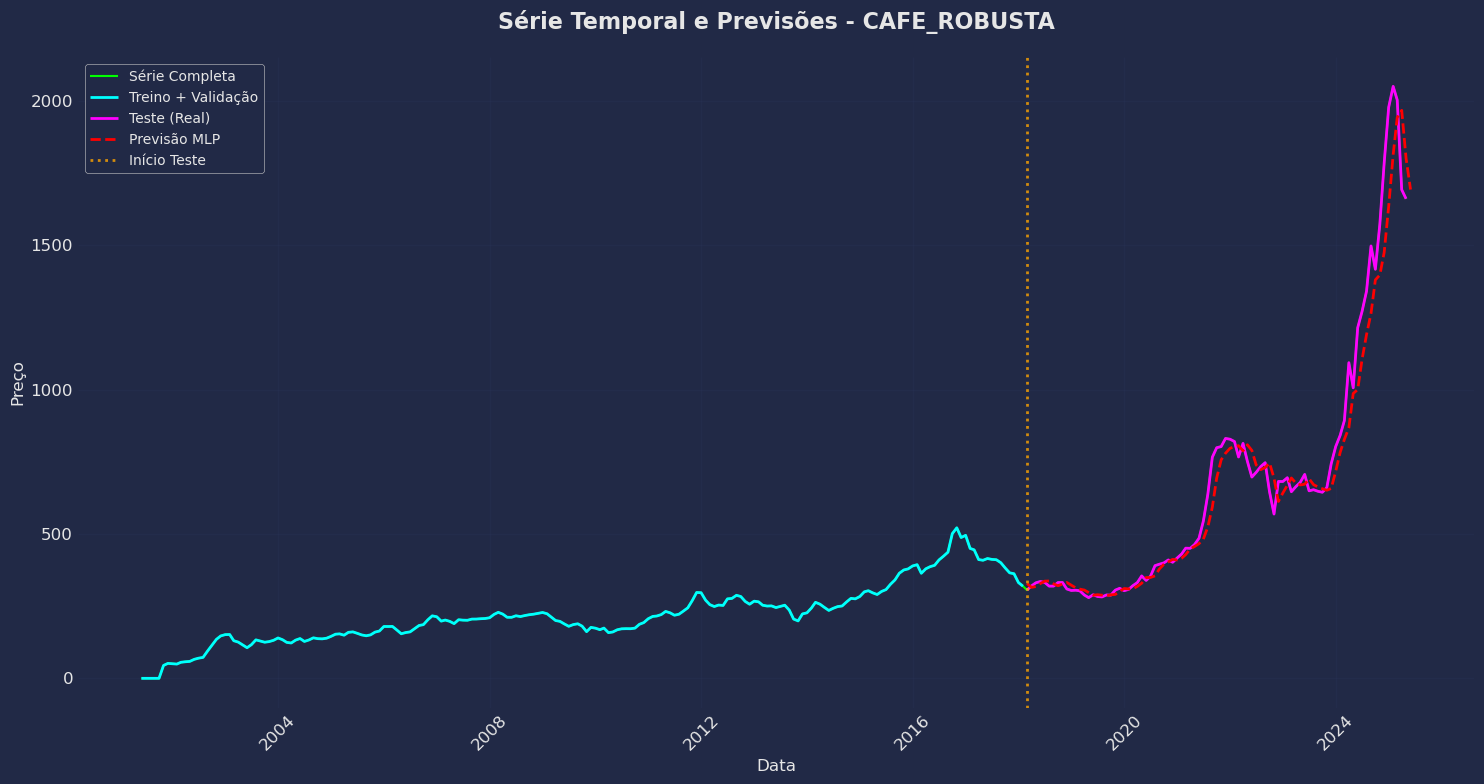

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


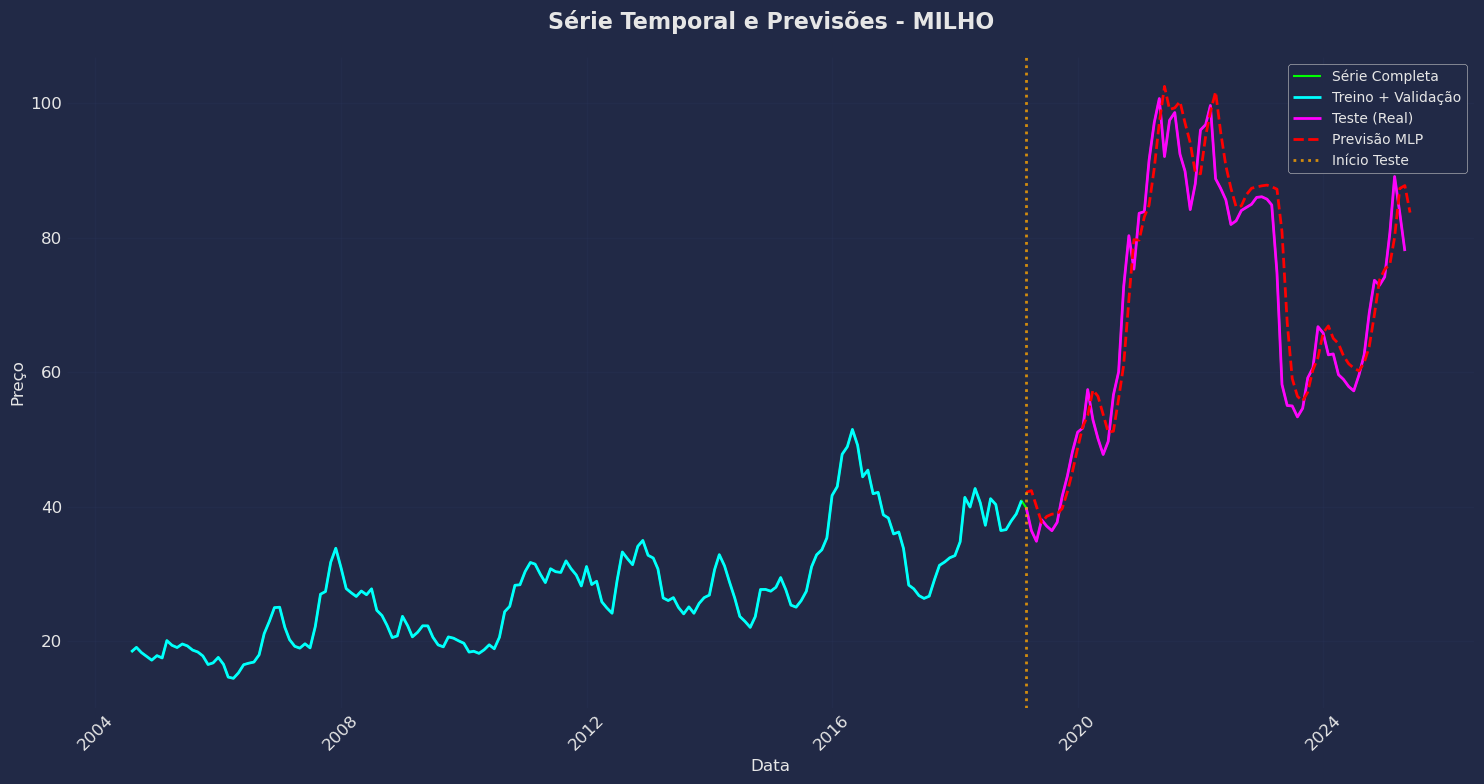

Gráfico exibido para: MILHO
--------------------------------------------------


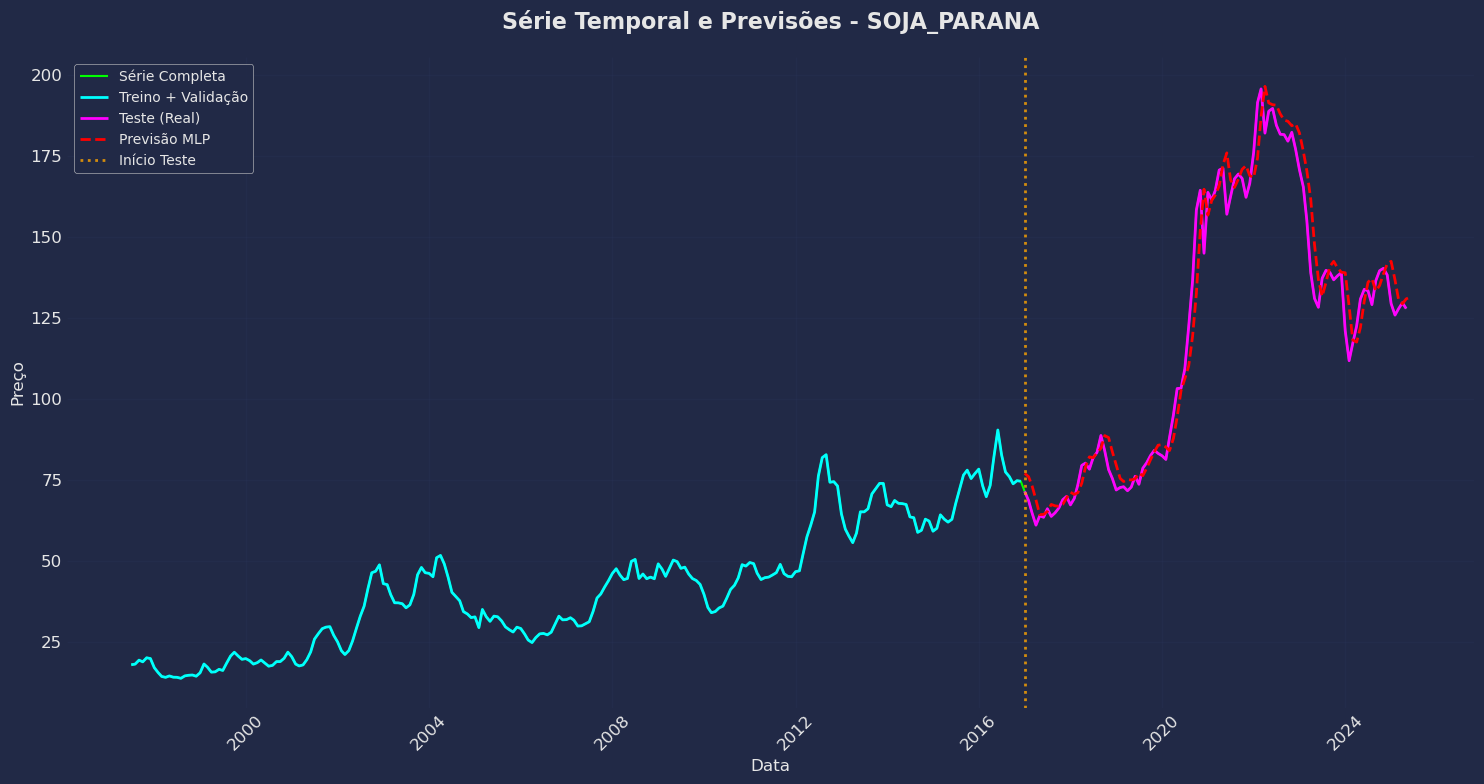

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


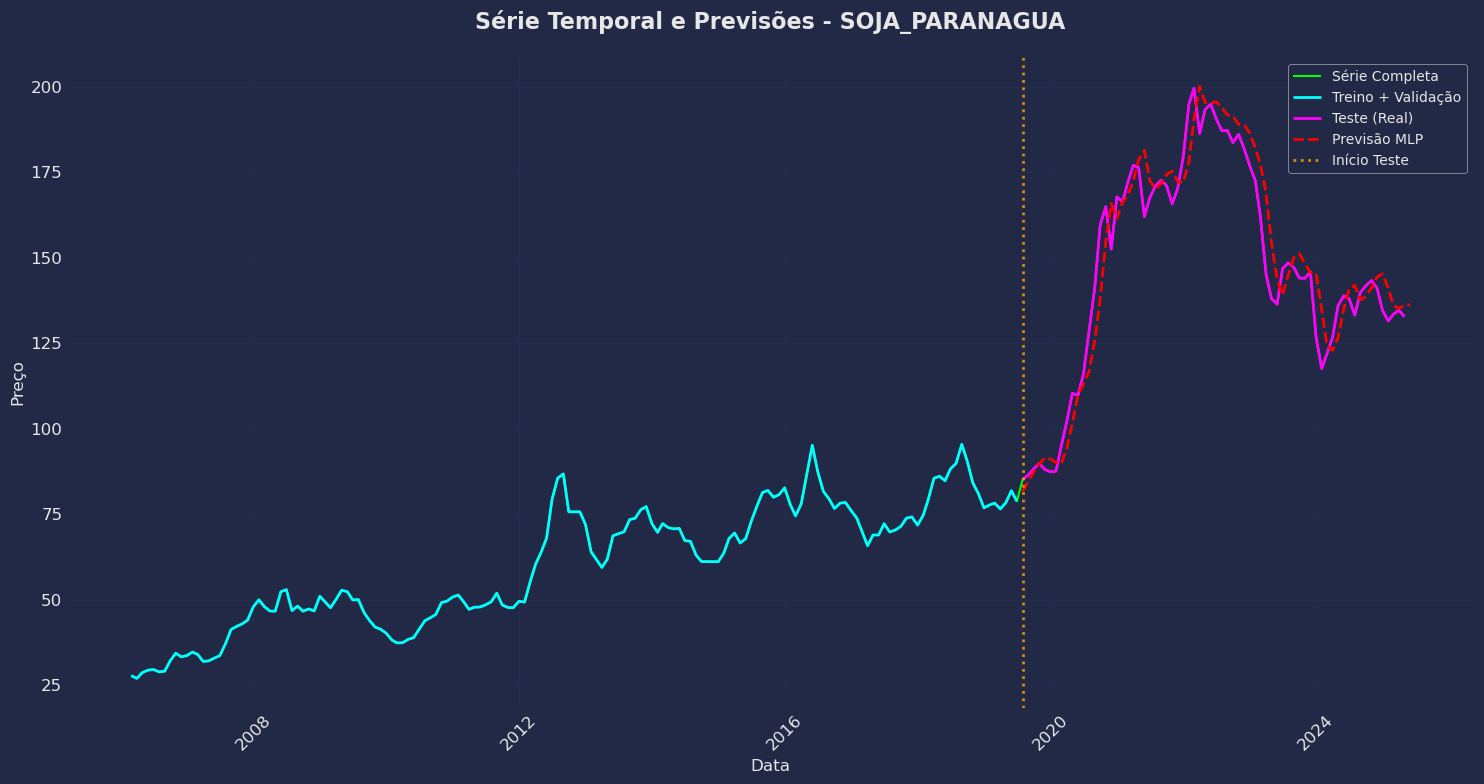

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


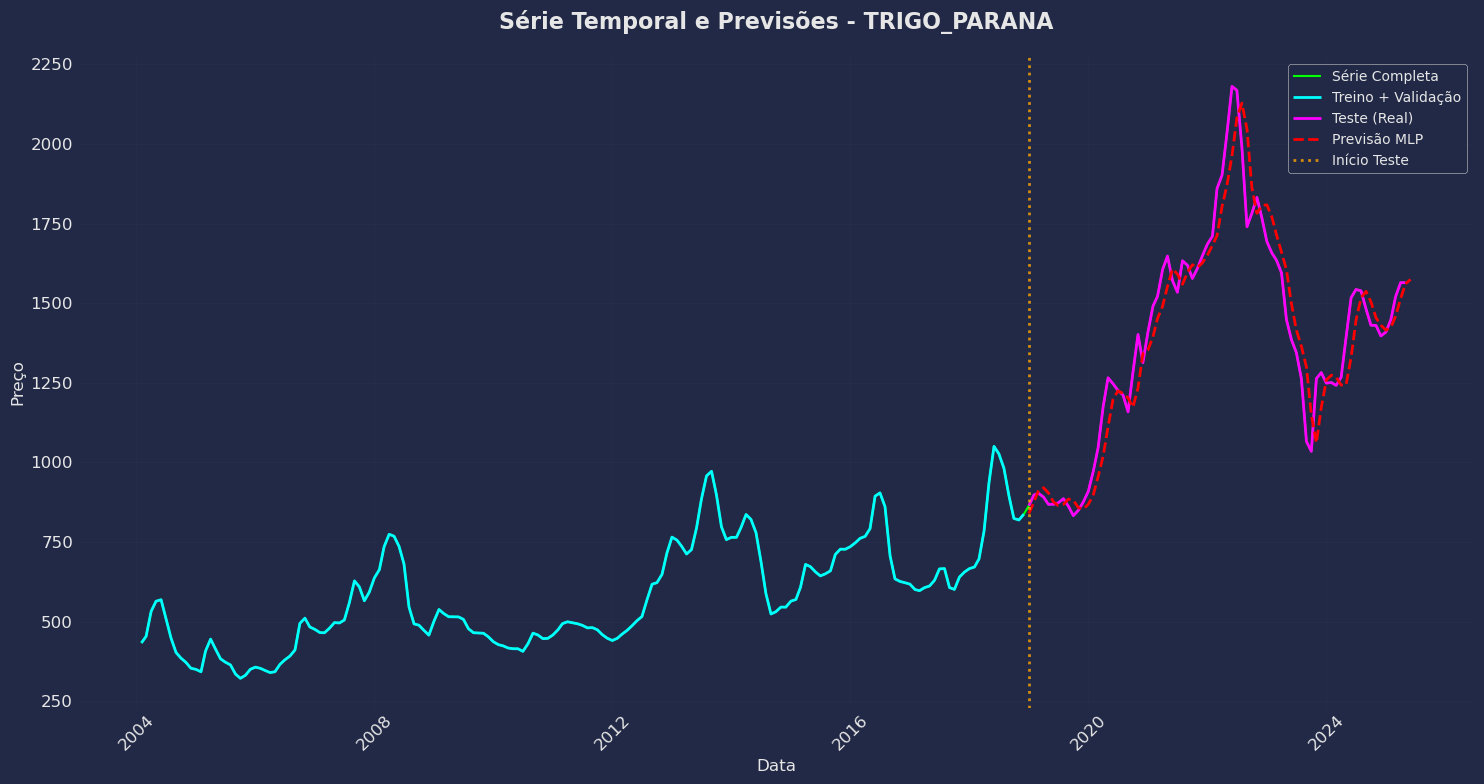

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


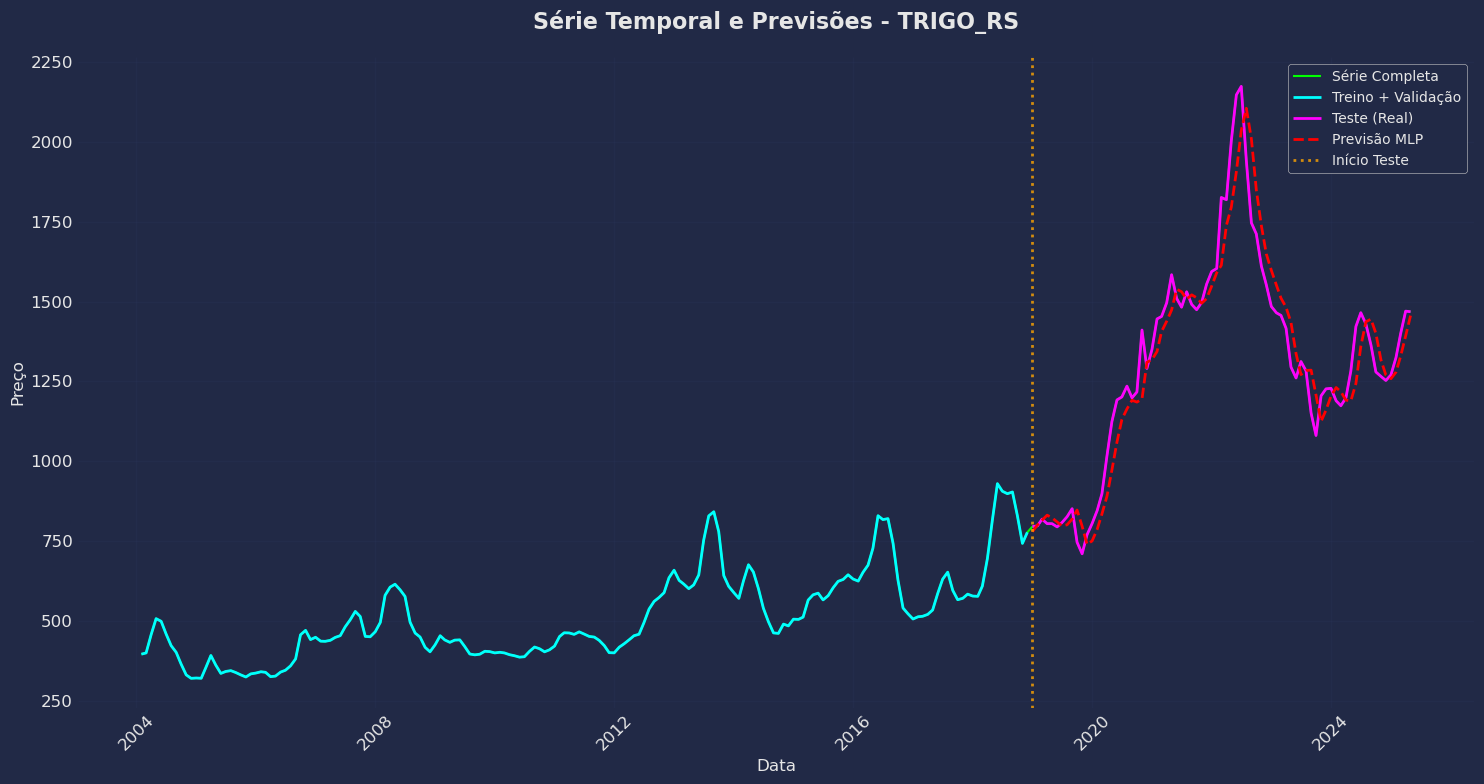

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [19]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['mlp'], 
                color='red', linewidth=2, linestyle='--', label='Previsão MLP')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

### Tunned

In [86]:
def mae_from_forecasts(forecasts_df, actual_df, model_col='mlp'):
    df = forecasts_df.merge(actual_df[['unique_id','ds','y']], 
                            on=['unique_id','ds'], how='inner')
    if len(df) == 0:
        return np.inf
    return mean_absolute_error(df['y'], df[model_col])

In [ ]:
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [
        (64, 32),
        (2,), (3,), (4,),
        (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,),
        (11,5,1), (9,9,1), (3,1,1), (9,3,1),
        (50,), (100,50), (50,50,50)
    ])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    learning_rate_init = trial.suggest_categorical("learning_rate_init", [0.001, 0.01, 0.1])
    max_iter = trial.suggest_categorical("max_iter", [50, 100, 500])
    
    # modelo pipeline com MinMaxScaler
    model = make_pipeline(
        MinMaxScaler(feature_range=(0,1)),
        MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            random_state=42
        )
    )
    
    fcst = MLForecast(models={'mlp': model}, lags=lags, freq='MS')
    fcst.fit(train)
    
    preds = []
    for i in range(len(val)):
        f_next = fcst.predict(h=1)
        preds.append(f_next)
        obs = val.iloc[[i]][['unique_id','ds','y']]
        fcst.update(obs)
    
    forecasts_df = pd.concat(preds, ignore_index=True)
    mae = mae_from_forecasts(forecasts_df, val, model_col='mlp')
    
    return mae

# file:.../salete,+12+APLICA%C3%87%C3%83O+DE+REDES+NEURAIS+ARTIFICIAIS+NA+PREVIS%C3%83O+DO+PRE%C3%87O+DO+MILHO+NO+ESTADO+DO+PARAN%C3%81%20(2).pdf
# https://www.sciencedirect.com/science/article/abs/pii/S0952197624016683?via%3Dihub
# https://www.sciencedirect.com/science/article/abs/pii/S1568494619306180?via%3Dihub
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10908409&tag=1
# https://onlinelibrary.wiley.com/doi/full/10.1002/isaf.1459
# https://link.springer.com/article/10.1007/s11540-024-09776-3#Tab6
# https://www.nature.com/articles/s41598-025-05103-z?fromPaywallRec=false
# https://www.nature.com/articles/s41598-025-05103-z?fromPaywallRec=false#Abs1
# https://arxiv.org/pdf/2403.04477
# https://pmc.ncbi.nlm.nih.gov/articles/PMC8459779/
# file:.../s11063-024-11578-0.pdf
# https://link.springer.com/article/10.1007/s11063-024-11578-0
# https://journaljerr.com/index.php/JERR/article/view/1188/2360

In [88]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

study.optimize(objective, n_trials=80, n_jobs=1)

print("Melhor score (val):", study.best_value)
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-10-10 21:36:54,597] A new study created in memory with name: no-name-9ccfd3c3-bb22-4dbb-9aaf-ba5fea207ac3
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2,) which is of type tuple.
  warnings.warn(message)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3,) which is of type tuple.
  warnings.warn(message)
/home/hiraeth/anaconda3/

Melhor score (val): 12.78317838689977
Melhores hiperparâmetros: {'hidden_layer_sizes': (13,), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.001, 'max_iter': 500}


In [89]:
best = study.best_params
mlp_best = MLPRegressor(
            hidden_layer_sizes=best['hidden_layer_sizes'],
            activation=best['activation'],
            solver=best['solver'],
            learning_rate_init=best['learning_rate_init'],
            max_iter=best['max_iter'],
            random_state=42
        )
model_best = make_pipeline(MinMaxScaler(feature_range=(0,1)), mlp_best)

fcst_final = MLForecast(models={'mlp': model_best}, lags=lags, freq='MS')
fcst_final.fit(full_train)

MLForecast(models=[mlp], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [17]:
import os
import joblib

SAVE_DIR = "/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/"

# Garante que o diretório exista
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model(model, name: str):
    """
    Salva modelos de sklearn, keras e pmdarima no formato adequado.

    Parâmetros:
    - model: objeto do modelo treinado
    - name: nome do arquivo (sem extensão)
    """
    path = os.path.join(SAVE_DIR, name)

    joblib.dump(model, f"{path}.pkl")
    print(f"✅ Modelo sklearn salvo em: {path}.pkl")

save_model(fcst_final, "mlp_tunned")

✅ Modelo sklearn salvo em: /home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/mlp_tunned.pkl


In [ ]:
forecasts = []
for i in range(len(test)):
    f_next = fcst_final.predict(h=1)
    forecasts.append(f_next)
    obs = test.iloc[[i]][['unique_id','ds','y']]
    fcst_final.update(obs)

forecasts_df = pd.concat(forecasts, ignore_index=True)

In [91]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['mlp'],         
    groupby_column='unique_id'     
)
print(results)
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

         unique_id Model  n_observations        MAE      MAPE           MSE  \
0    ACUCAR_SANTOS   mlp              19   7.728671  0.052872     99.599082   
1        ACUCAR_SP   mlp              79   5.991330  0.051836     62.031165   
2          ALGODAO   mlp             104  21.407995  0.053136    981.674145   
3            ARROZ   mlp              71   6.216271  0.074407     69.613005   
4     CAFE_ARABICA   mlp             103  86.892451  0.094537  21598.217077   
5     CAFE_ROBUSTA   mlp              86  64.469345  0.091576  11933.938657   
6            MILHO   mlp              74   4.787671  0.075400     41.242862   
7      SOJA_PARANA   mlp             100   6.126547  0.052762     72.528569   
8   SOJA_PARANAGUA   mlp              69   7.173017  0.050947     84.941000   
9     TRIGO_PARANA   mlp              76  76.696153  0.055357  10059.096550   
10        TRIGO_RS   mlp              76  77.243681  0.058989   9922.512463   

          RMSE        R2  
0     9.979934 -0.100008

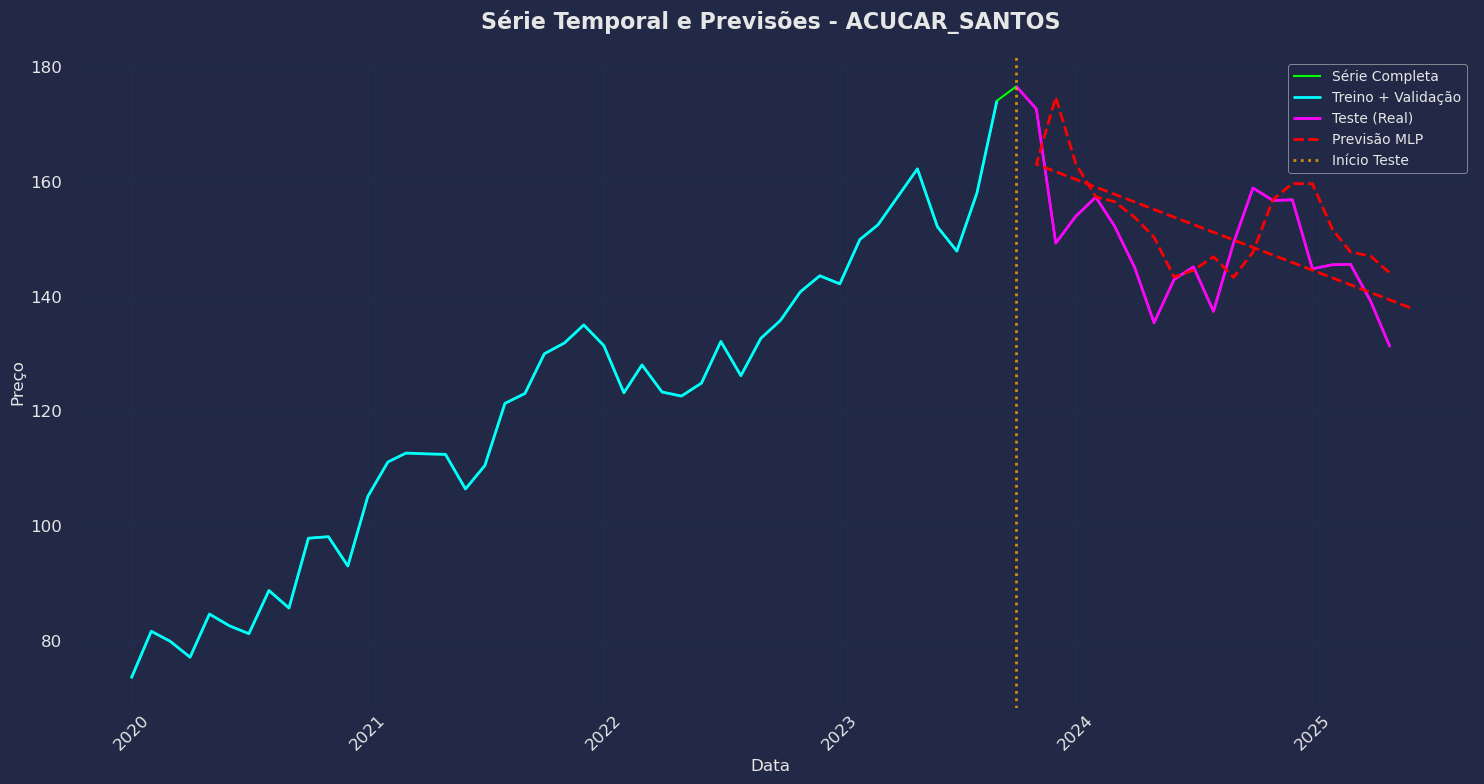

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


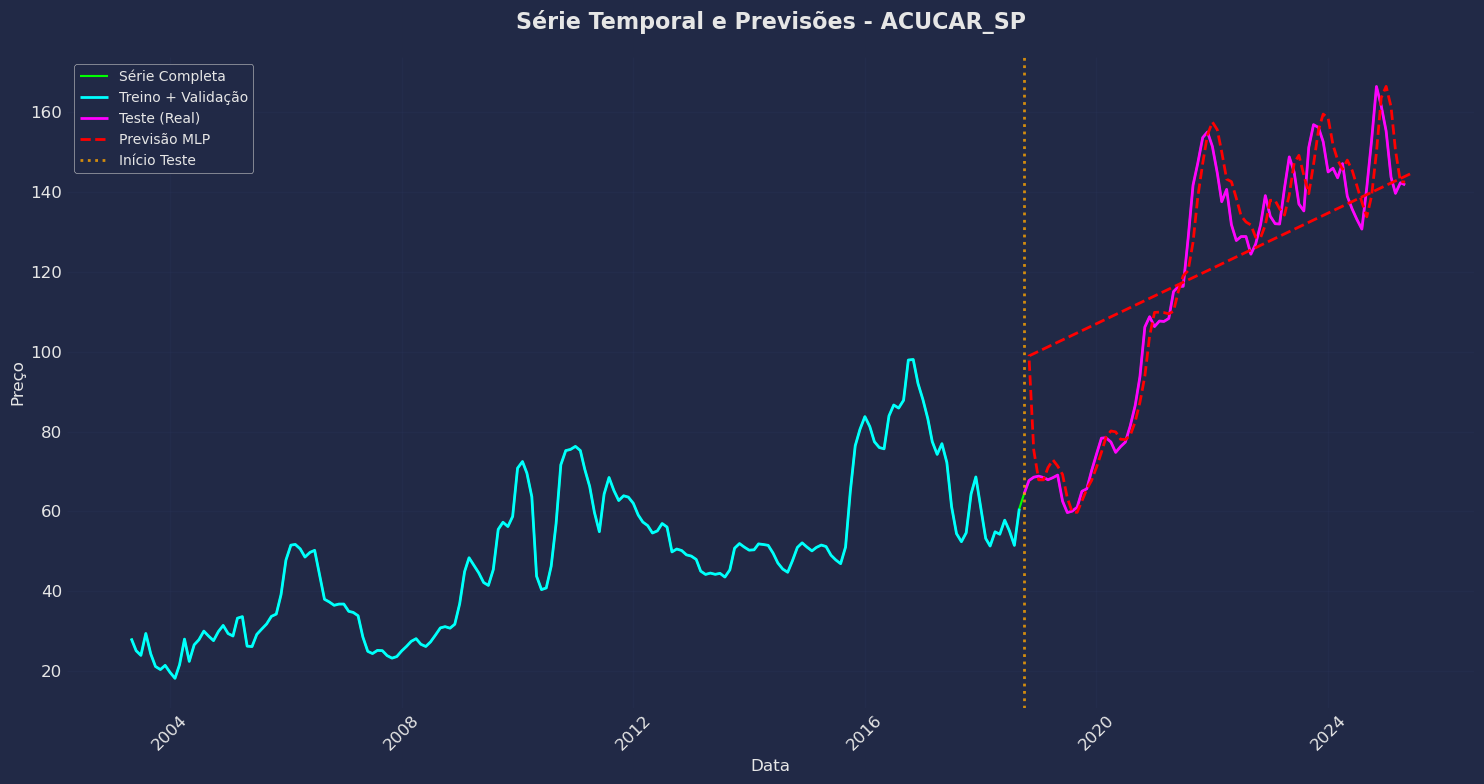

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


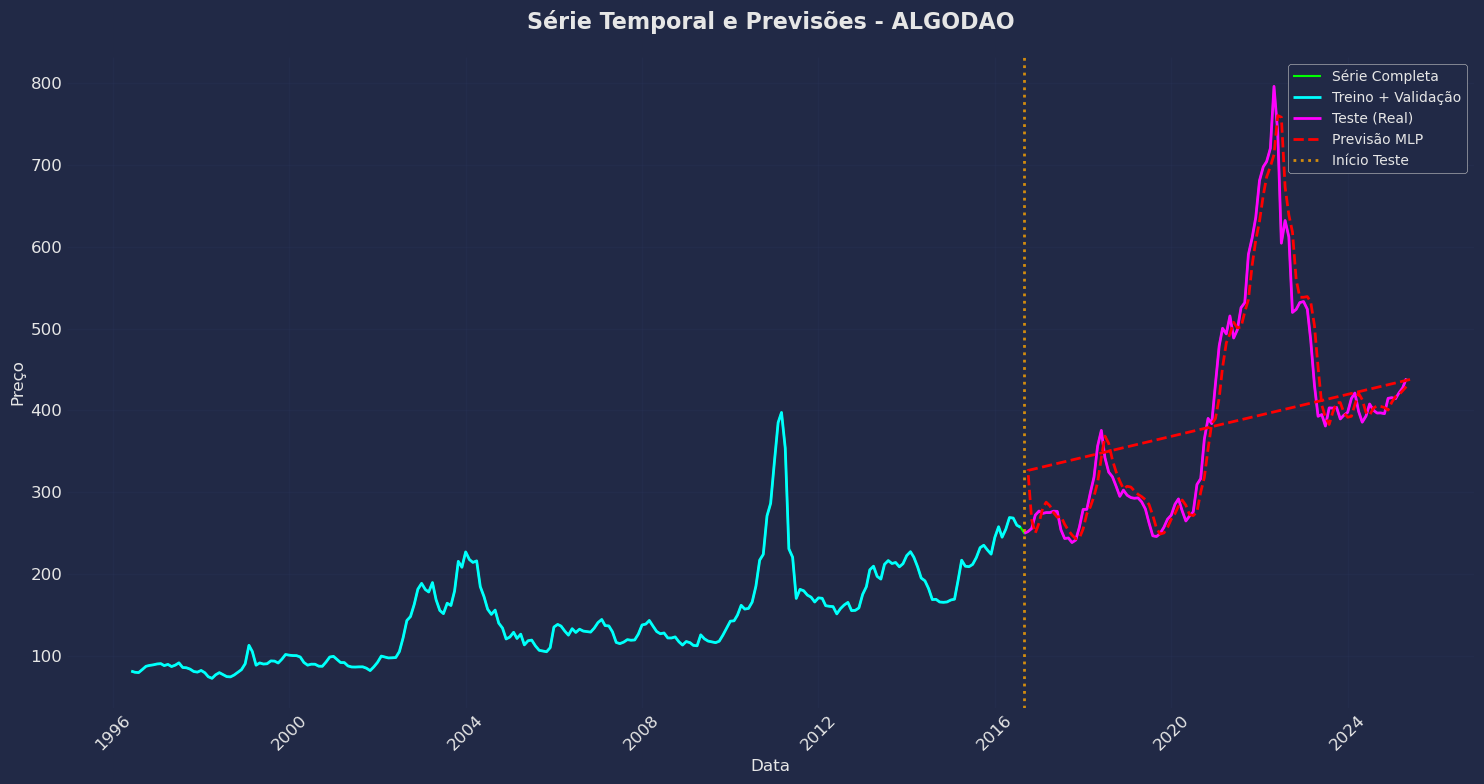

Gráfico exibido para: ALGODAO
--------------------------------------------------


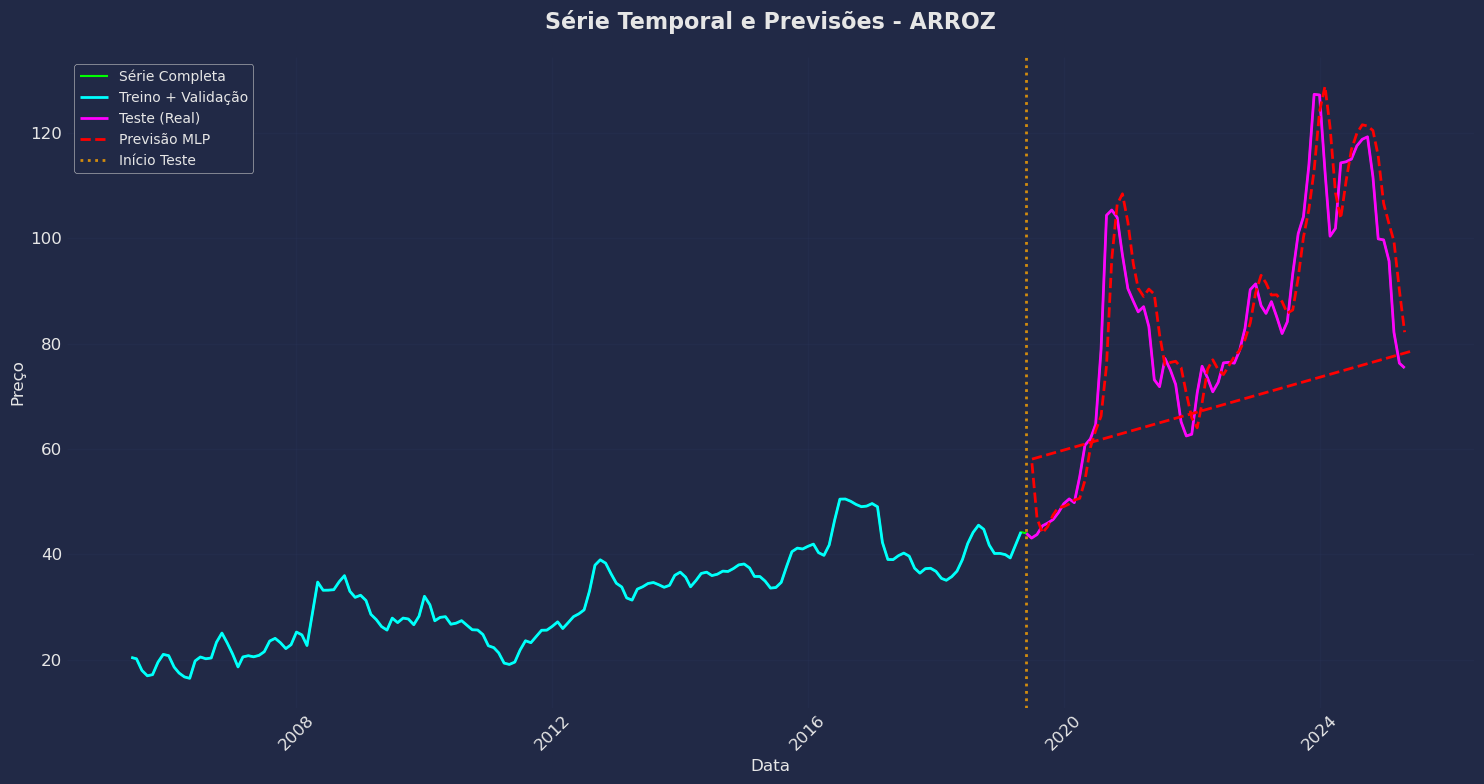

Gráfico exibido para: ARROZ
--------------------------------------------------


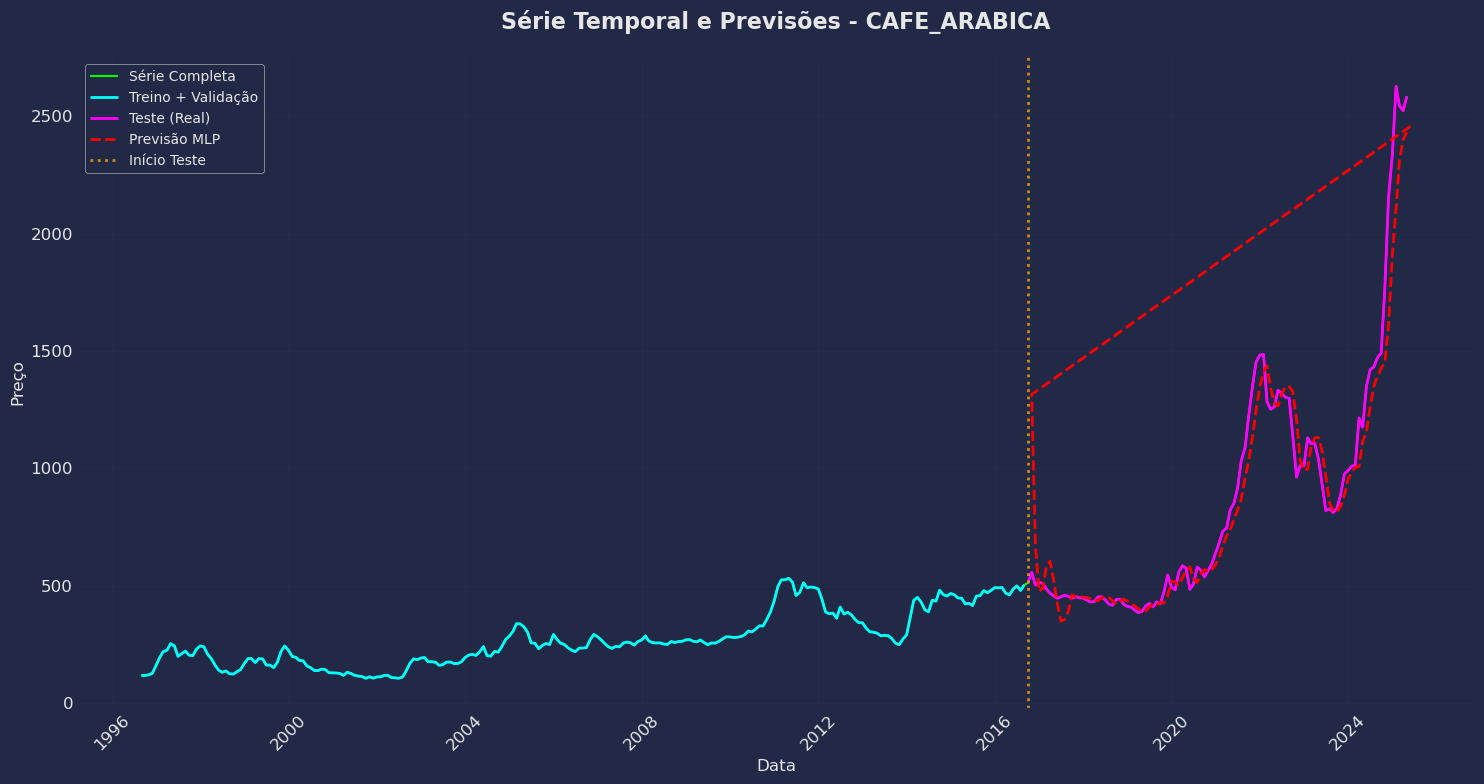

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


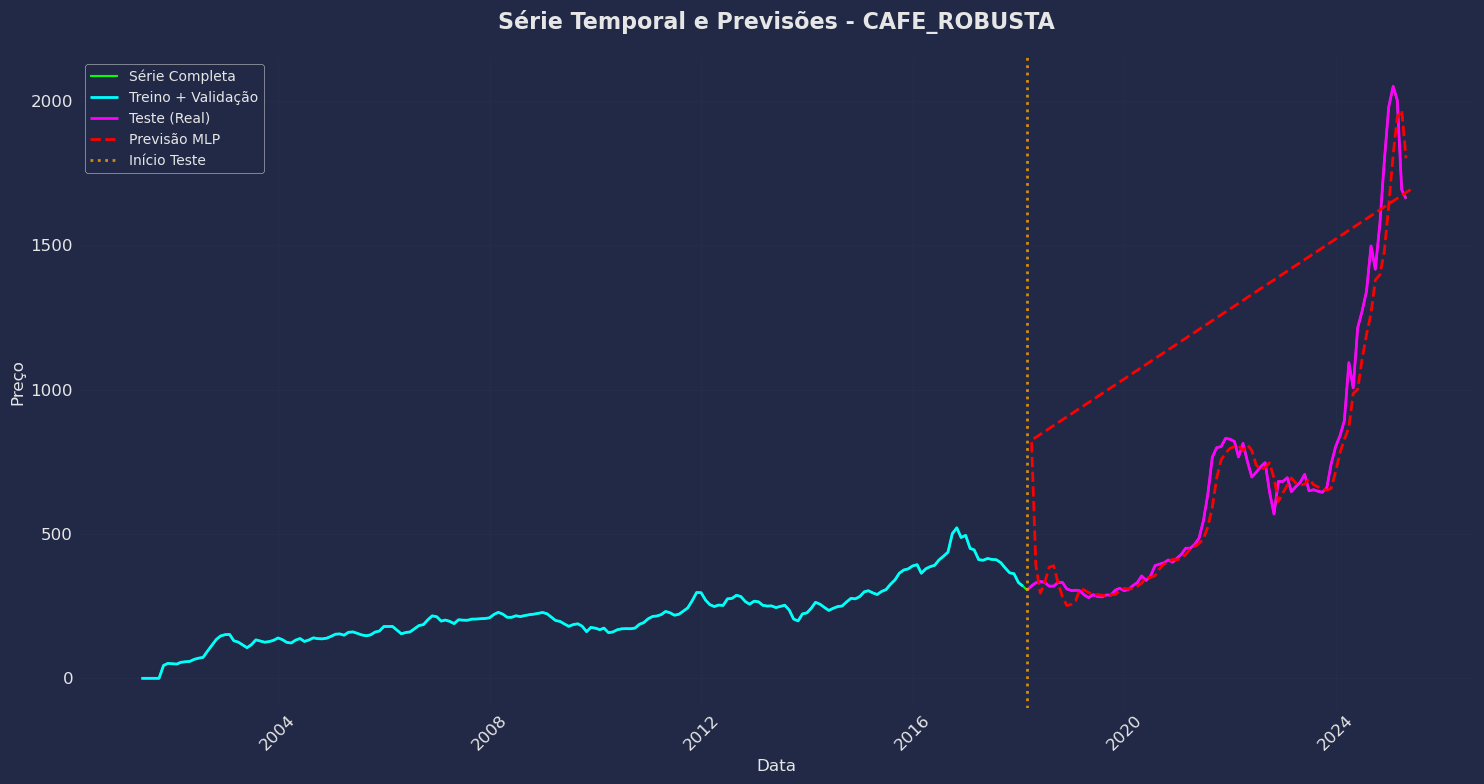

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


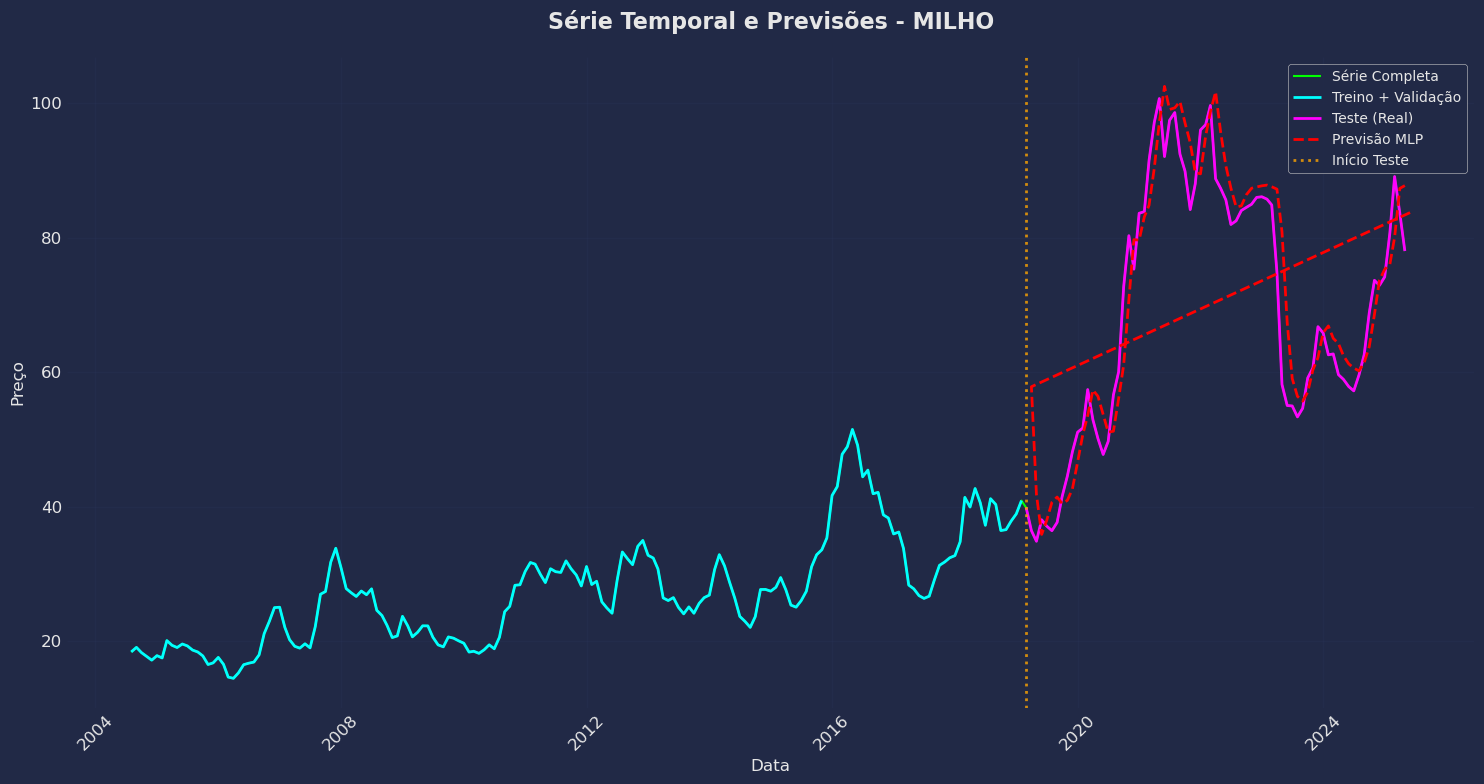

Gráfico exibido para: MILHO
--------------------------------------------------


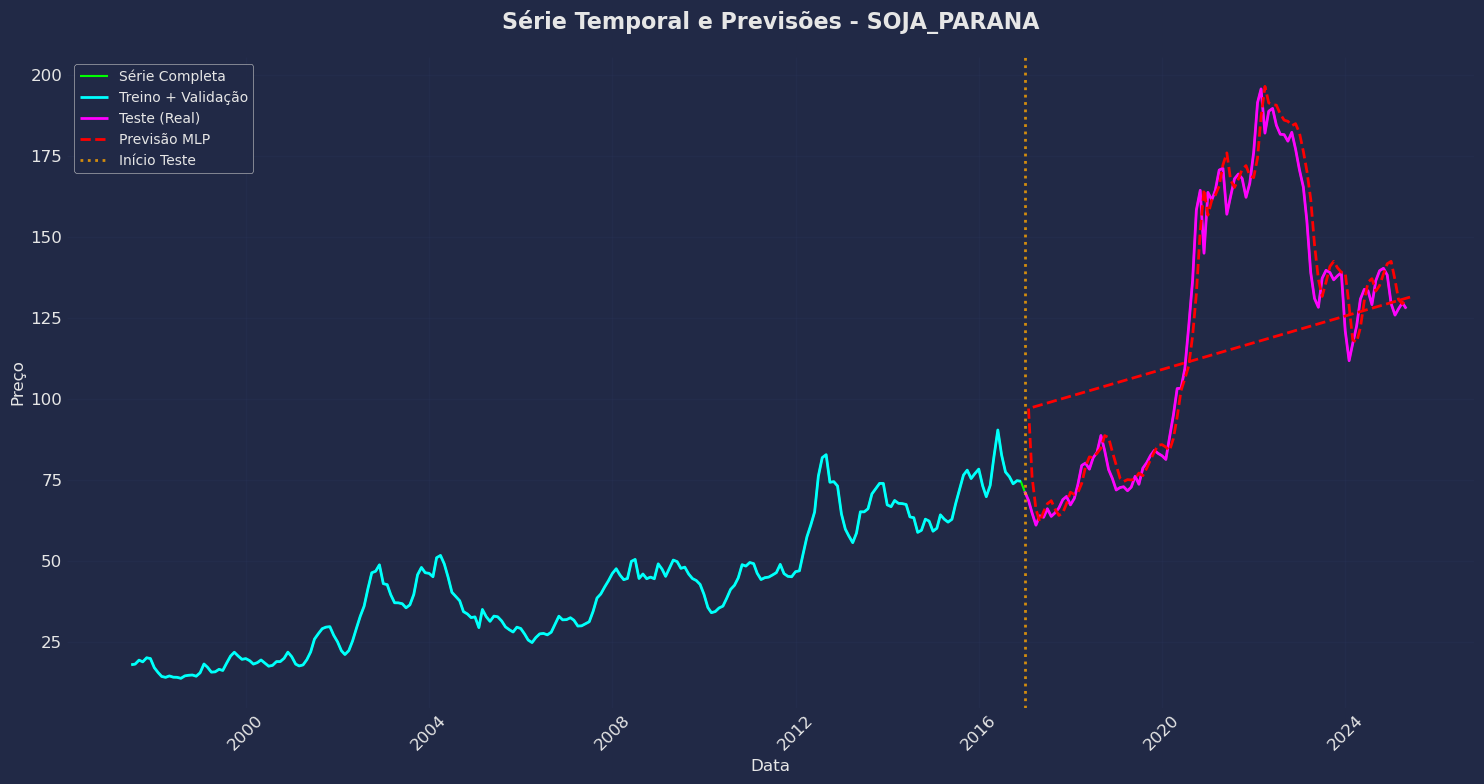

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


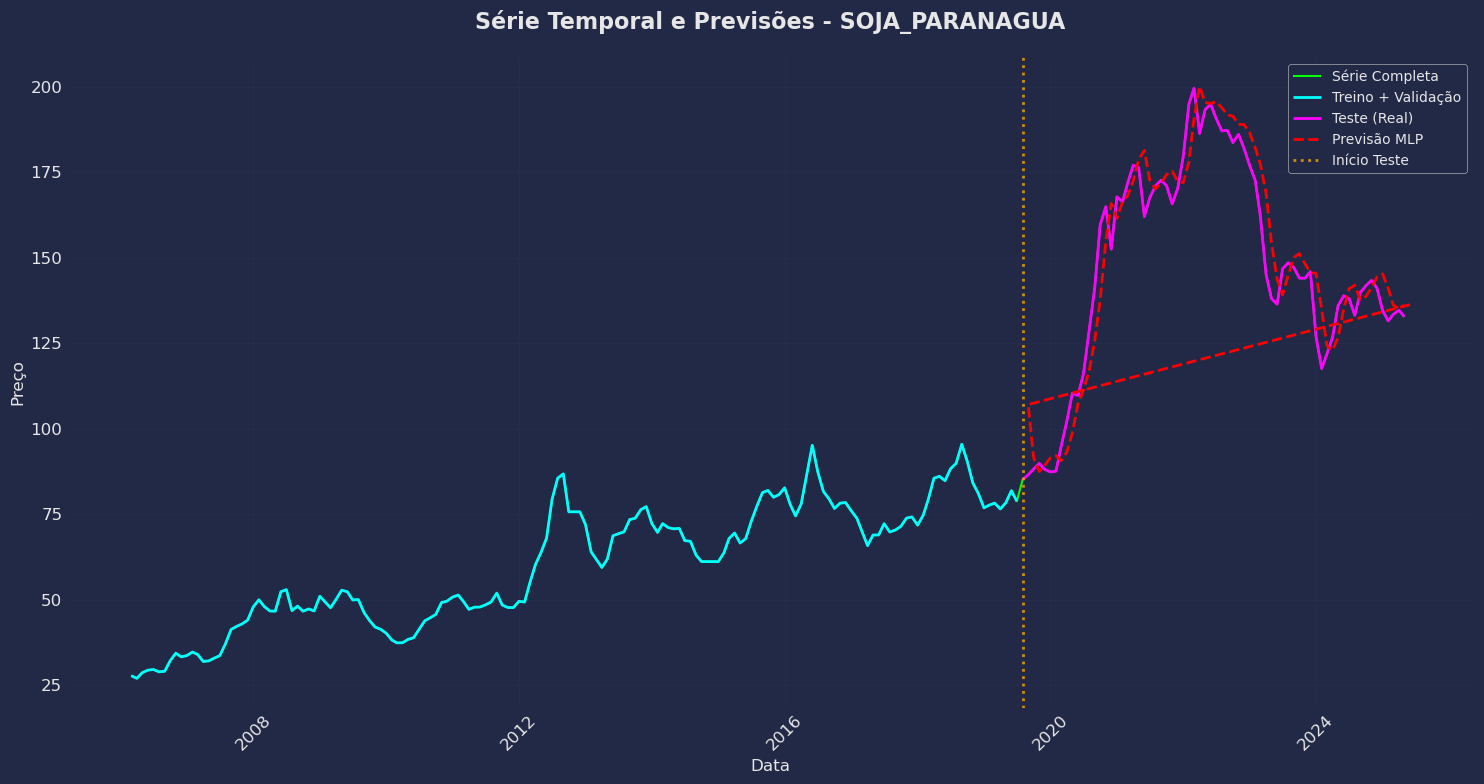

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


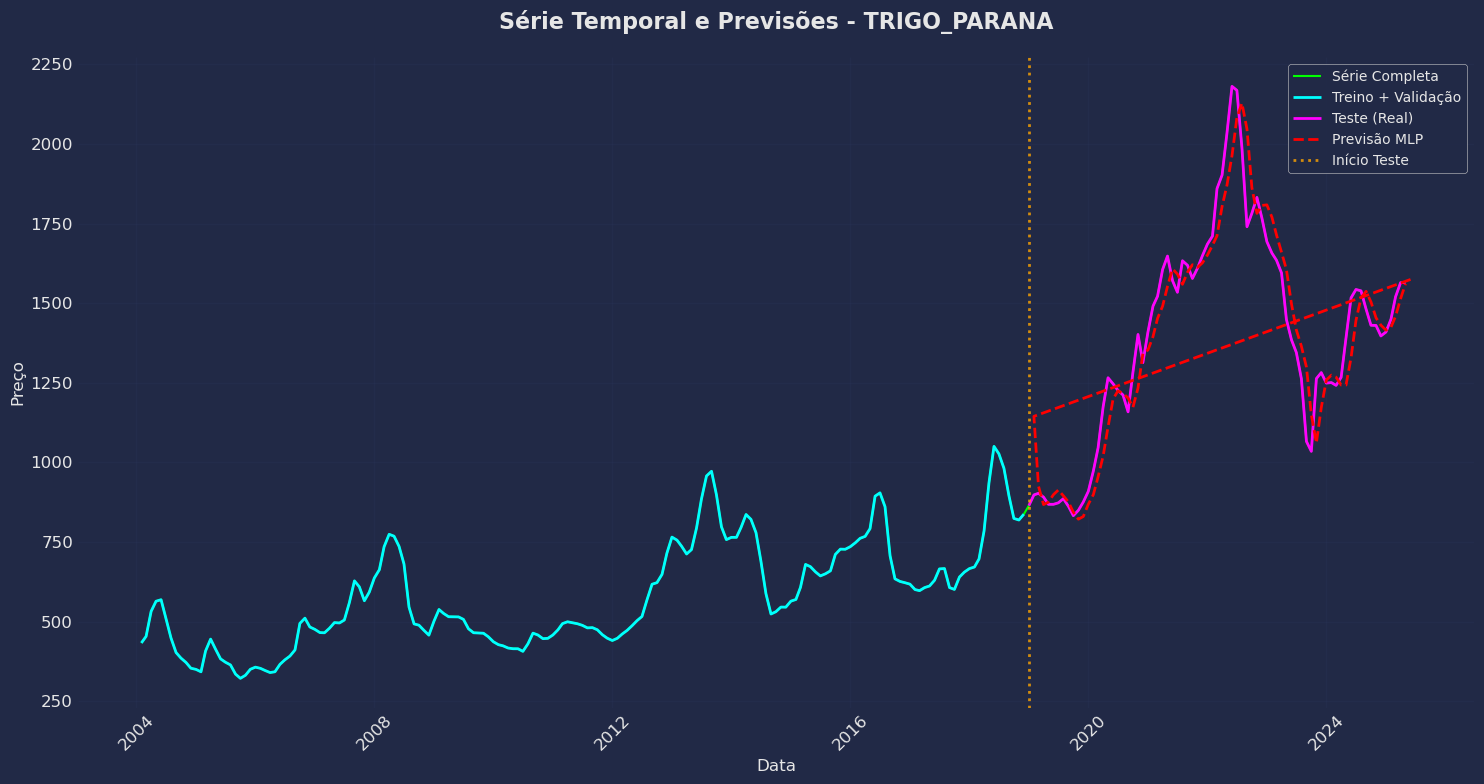

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


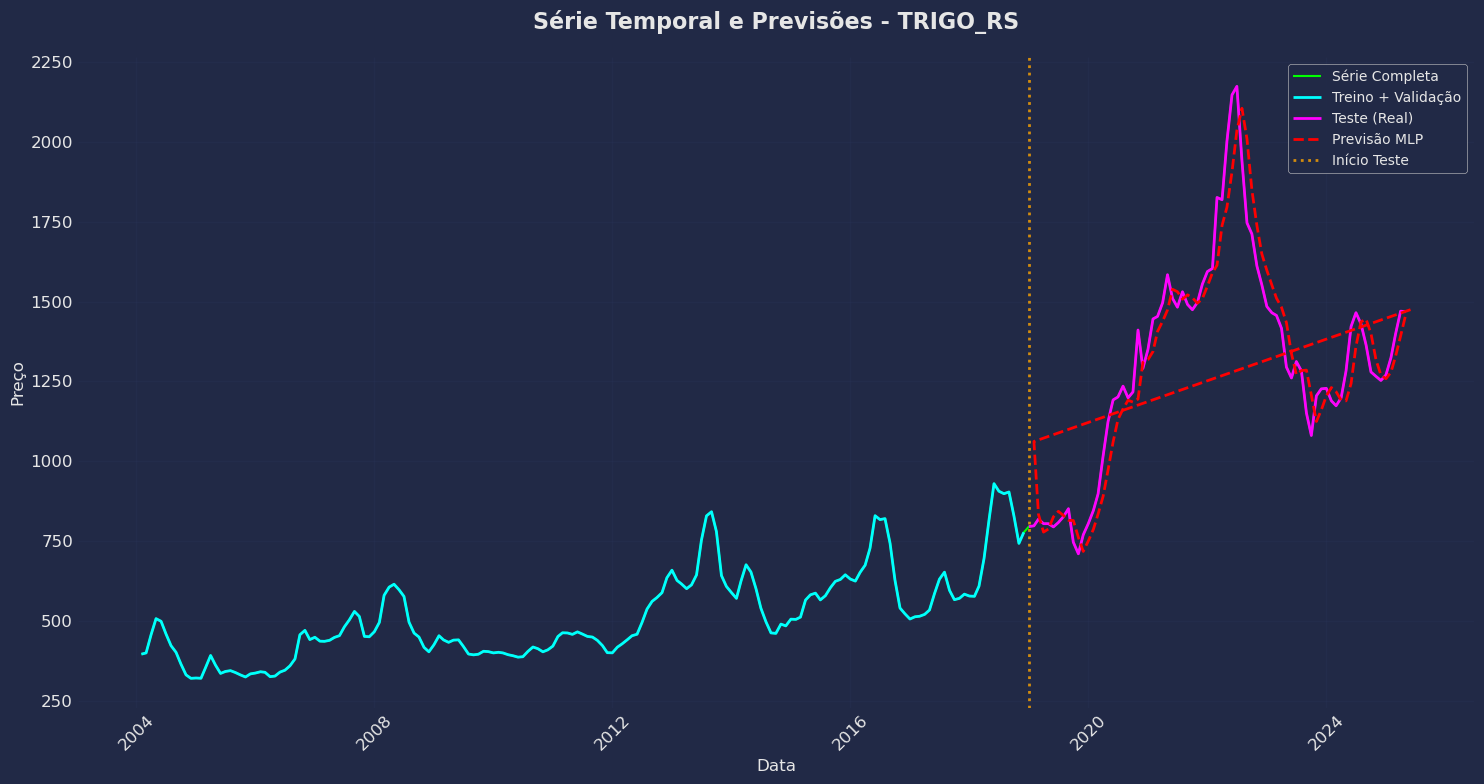

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [92]:
plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)